In [1]:
# GEO prefix implies geo_env (geopandas/arcgis enabled)
# https://geopandas.org/install.html#creating-a-new-environment
! echo $CONDA_DEFAULT_ENV

geo_env


In [2]:
# standard imports
import sys
import getpass
user = getpass.getuser()
sys.dont_write_bytecode = True
sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))
from utils_io import *

In [3]:
# geo imports
import geopandas as gpd

In [4]:
# plot imports
import contextily as ctx
import matplotlib.pyplot as plt

# SF Example: Parcel Ranking + visualization

This notebook demonstrates how we could pre-filter parcels by assigning ranks based on qualitative judgements of the fields we added in the previous notebooks, assigned as a score.

## Steps

### Step 8: Assign score based on fields

### Step 9: Visualize on a map

Pre-step: pull [Housing Element Site Selection Parcels v3](https://data.bayareametro.gov/Land-People/Housing-Element-Site-Selection-Parcels-v3/d8wd-vg4y)

In [5]:
# pull from Socrata
geojson = pull_geojson_from_socrata('d8wd-vg4y')

pulling 2142677 rows as geojson


In [6]:
gdf = gpd.GeoDataFrame.from_features(geojson['features'],
                                     crs='EPSG:4326')

In [7]:
all_null = gdf[[c for c in gdf if c != 'geometry']].isnull().all(axis=0)
drop_cols = list(all_null[all_null == True].index)
drop_cols

['vmt',
 'urban_serv',
 'bldg_permi',
 'gp_max_dua',
 'exist_lu',
 'gp_description',
 'gp_code',
 'vacant',
 'underutilized',
 'public_own']

In [8]:
gdf = gdf.drop(drop_cols, axis=1)

## Step 8: Assign score based on fields

### 1. reso_level

Good (+1):
- 'Highest Resource'
- 'High Resource'

Moderate (+0?):
- 'Moderate Resource'


Bad (-1):
- 'High Segregation & Poverty'
- 'Moderate Resource (Rapidly Changing)'
- 'Low Resource'

In [9]:
gdf['reso_level'].unique()

array(['Moderate Resource', 'Highest Resource', 'Low Resource',
       'High Resource', 'Moderate Resource (Rapidly Changing)',
       'High Segregation & Poverty', None], dtype=object)

In [10]:
reso_map = {'Highest Resource': 1,
            'High Resource': 1,
            'Moderate Resource': 0,
            'Moderate Resource (Rapidly Changing)': -1,
            'Low Resource': -1,
            'High Segregation & Poverty': -1}

gdf['reso_pts'] = gdf['reso_level'].map(reso_map)

### 2. pda

Good (+1):
`pda == '1'`

In [11]:
gdf['pda'].unique()

array(['0', '1'], dtype=object)

In [12]:
pda_map = {'1': 1}

gdf['pda_pts'] = gdf['pda'].map(pda_map)

### 3. cpad

Bad (-1): `cpad == '1'`

In [13]:
gdf['cpad'].unique()

array(['0', '1'], dtype=object)

In [14]:
cpad_map = {'1': -1}

gdf['cpad_pts'] = gdf['cpad'].map(cpad_map)

### 4. tra

Good (+1): `tra == '1'`

In [15]:
gdf['tra'].unique()

array(['0.0', '1.0'], dtype=object)

In [16]:
tra_map = {'1.0': 1}

gdf['tra_pts'] = gdf['tra'].map(tra_map)

### 4. fire_risk

Bad (-1):
- 'Moderate'
- 'High'

Very bad (-2):
- 'Very High'

In [19]:
gdf['fire_risk'].unique()

array([None, 'High', 'Moderate', 'Very High'], dtype=object)

In [20]:
fire_risk_map = {'Moderate': -1,
                 'High': -1,
                 'Very High': -2}

gdf['fire_risk_pts'] = gdf['fire_risk'].map(fire_risk_map)

### 5. sea_level

Bad (-1): `sea_level == '1'`

In [22]:
gdf['sea_level'].unique()

array(['1', '0'], dtype=object)

In [23]:
sea_level_map = {'1': -1}
gdf['sea_level_pts'] = gdf['sea_level'].map(sea_level_map)

### Summarize



In [24]:
pts_cols = [c for c in gdf if c.endswith('_pts')]
pts_cols

# ['reso_pts',
#  'pda_pts',
#  'cpad_pts',
#  'tra_pts',
#  'fire_risk_pts',
#  'sea_level_pts']

['reso_pts',
 'pda_pts',
 'cpad_pts',
 'tra_pts',
 'fire_risk_pts',
 'sea_level_pts']

In [26]:
gdf[pts_cols] = gdf[pts_cols].fillna(0)
gdf['pt_sum'] = gdf[pts_cols].sum(axis=1)

In [28]:
gdf['pt_sum'].unique()

array([-1.,  0.,  2., -2.,  1.,  3., -3., -4.])

## Step 9: Show example map of SF

Show parcels with [diverging color scale](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#diverging)

In [29]:
sf_parcels = gdf[gdf['city'] == 'San Francisco']
len(sf_parcels)  # 221345

In [33]:
a = time.time()
parcels_centroid = gpd.GeoDataFrame(sf_parcels,
                                    geometry=gpd.points_from_xy(sf_parcels['centroid_x'],
                                                                sf_parcels['centroid_y']),
                                    crs='EPSG:4326')
b = time.time()
print('took {}'.format(print_runtime(b-a)))
# took 1.5549 seconds

took 1.5549 seconds


### Only look at interesting parcels

In [37]:
parcels_centroid = parcels_centroid[parcels_centroid['pt_sum'] != 0]
print(len(parcels_centroid))  # 209829

209829


In [38]:
parcels_centroid.head().T

,9,10,11,15,17
geometry,POINT (-122.3918513532 37.7886820162196),POINT (-122.3918513532 37.7886820162196),POINT (-122.3918513532 37.7886820162196),POINT (-122.475133133233 37.7464327954809),POINT (-122.496834014 37.7640057875001)
rhna_4,0,0,0,0,0
fmr_3bdr,3663.0,3663.0,3663.0,3663.0,3663.0
parcel_type,PT20,PT20,PT20,PT00,PT00
city,San Francisco,San Francisco,San Francisco,San Francisco,San Francisco
acres,1.73007546330161,1.73007546330161,1.73007546330161,0.055750969348474,0.0686120525227863
geom_id,4117996814145245402,4117996814145245402,4117996814145245402,N914452897973902589,4727775622524550904
reso_level,Moderate Resource,Moderate Resource,Moderate Resource,Highest Resource,High Resource
sea_level,0,0,0,0,0
blkgp_geoi,060750615003,060750615003,060750615003,060750304004,060750351001


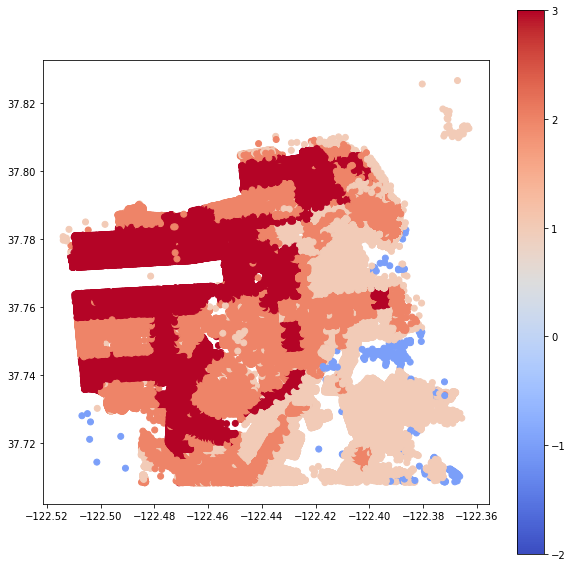

In [39]:
parcels_centroid.plot(figsize=(10,10),
                      column='pt_sum',
                      legend=True,
                      cmap='coolwarm');

### Show bad parcels

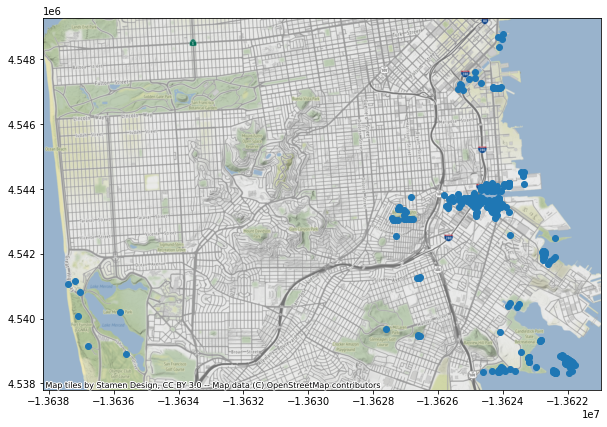

In [47]:
bad = parcels_centroid[parcels_centroid['pt_sum'] < 0].to_crs('epsg:3857')
ax = bad.plot(figsize=(10,10))
ctx.add_basemap(ax)